In [102]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

Our dataset appears to consist of two types of samples - bid samples, and ad samples. Since we are only trying to predict clicks on the ad, AKA "c_cnt", which only exists in ad samples, we will only be working with those data. Let's first parse the data and get what we need.

In [2]:
#reads a weird json, and returns the bids dataframe and ads dataframe
def read_weird_json(path):
    bids = []
    ads = []

    with open(path) as f:
        for line in f:
            line_dict = json.loads(line)
            if 'advertiser_id' in line_dict:
                if line_dict['rate_metric'] != 'CPC':
                    continue
                ads.append(line_dict)
            else:
                bids.append(line_dict)

    df_bids = pd.DataFrame.from_records(bids)
    df_ads = pd.DataFrame.from_records(ads)  
    
    return [df_bids, df_ads]

#Returns a list of dataframes. Only looks at ads. 
def read_many_jsons(paths): 
    dfs = []
    for path in paths: 
        dfs += [read_weird_json(path)[1]]
    return dfs
    
dfs = read_many_jsons(['./11-0', './11-1', './11-2', './11-3'])
#'./11-4', './11-5', './11-6', './11-7', './11-8', './11-9', './11-10'])

In [132]:
#Create one dataframe with the combined data. 
df = pd.concat(dfs)

Now, we need to do some data cleaning. From some initial exploratory analysis, we can see that that we have 5 features with only 16 non-nan values, with a few other features having a similarly low level of non-nan values. To simplify things, we choose to drop all features with less than 20,000 non-nan values. Also, as we are trying to predict c_cnt, samples where c_cnt is NaN are useless, so we throw those away as well. 

After this, we see that less than 10% of our remaining samples contains any NaN values, so we just drop those samples as we don't lose that much information from them.

In [133]:
#how many non-nan values do we have?
print(df.count())

#filter threshhold
df = df.dropna(thresh=20000, axis=1)
#filter rows with c_cnt as NaN
df = df[np.isfinite(df['c_cnt'])]
#drop all samples with NaN values
df = df.dropna(axis=0)

ad_network_id            1005218
ad_type                  1005218
advertiser_id            1005218
bid_requests             1005218
bid_responses            1005218
c_cnt                     847978
c_timestamp                  402
c_txn_fee                    402
c_txn_rate                   402
campaign_id              1005218
campaign_type            1005218
cr_cnt                   1005218
creative_id              1005218
exp_mode                  154801
f_cnt                     847978
geo_continent_code       1005218
geo_country_code2        1005218
geo_dma_code             1005218
geo_region_name           986891
geo_timezone              990266
i_cnt                     847978
i_timestamp               847510
pub_network_id           1005218
r_cnt                    1005218
r_num_ads_requested      1005218
r_num_ads_returned       1005218
r_num_ads_third_party    1005218
r_timestamp              1005218
rate_metric              1005218
session_id               1005218
site_id   

In [134]:
df.shape

(21242, 37)

In [135]:
result = df.copy()
result = result[['c_cnt', 'vi_cnt', 'i_cnt', 'advertiser_id', 'pub_network_id', 'site_id', 'ua_device_type']]
collective = result.groupby(['advertiser_id', 'ua_device_type'])['c_cnt', 'vi_cnt', 'i_cnt'].sum()
advertisers_c_cnt = result.groupby(['advertiser_id', 'ua_device_type'])['c_cnt'].sum()
advertisers_vi_cnt = result.groupby(['advertiser_id', 'ua_device_type'])['vi_cnt'].sum()
advertisers_i_cnt = result.groupby(['advertiser_id', 'ua_device_type'])['i_cnt'].sum()

collective['total_count'] = result.groupby(['advertiser_id', 'ua_device_type']).count()['site_id']
collective['c_cnt/v_cnt'] = advertisers_c_cnt/advertisers_vi_cnt
collective['vi_cnt/i_cnt'] = advertisers_vi_cnt/advertisers_i_cnt
collective['c_cnt/i_cnt'] = advertisers_c_cnt/advertisers_i_cnt

collective.drop(columns=['c_cnt', 'vi_cnt', 'i_cnt'], inplace=True)
collective.reset_index(inplace=True)

collective.fillna(value=0, inplace=True)

collective

,advertiser_id,ua_device_type,total_count,c_cnt/v_cnt,vi_cnt/i_cnt,c_cnt/i_cnt
0,5063,BOT,1,0.000000,0.0,0.000000
1,5063,MOB,5611,0.006060,1.0,0.006060
2,5063,PC,3336,0.006295,1.0,0.006295
3,5063,TAB,1954,0.014841,1.0,0.014841
4,5152,MOB,4788,0.010234,1.0,0.010234
5,5152,PC,1831,0.007100,1.0,0.007100
6,5152,TAB,1534,0.011734,1.0,0.011734
7,5189,MOB,712,0.009831,1.0,0.009831
8,5189,PC,1228,0.002443,1.0,0.002443
9,5189,TAB,247,0.008097,1.0,0.008097


In [136]:
df = pd.merge(df, collective, on=['advertiser_id', 'ua_device_type'])
df.head()

,ad_network_id,ad_type,advertiser_id,bid_requests,bid_responses,c_cnt,campaign_id,campaign_type,cr_cnt,creative_id,...,ua_name,ua_os_name,vi_cnt,vi_timestamp,vv_cnt,zone_id,total_count,c_cnt/v_cnt,vi_cnt/i_cnt,c_cnt/i_cnt
0,727,[story],5152,[],[],0.0,26038,outside,1,4602192,...,Mobile Safari UI/WKWebView,iOS,1.0,2018-02-11T00:52:50.304000Z,0.0,14414,4788,0.010234,1.0,0.010234
1,727,[story],5152,[],[],0.0,26038,outside,1,4602194,...,Mobile Safari UI/WKWebView,iOS,1.0,2018-02-11T00:09:41.882000Z,0.0,14414,4788,0.010234,1.0,0.010234
2,727,[story],5152,[],[],0.0,26038,outside,1,4602192,...,Chrome Mobile,Android,1.0,2018-02-11T00:30:02.819000Z,0.0,14414,4788,0.010234,1.0,0.010234
3,727,[story],5152,[],[],0.0,26038,outside,1,4602192,...,Mobile Safari UI/WKWebView,iOS,1.0,2018-02-11T00:22:32.287000Z,0.0,14414,4788,0.010234,1.0,0.010234
4,727,[story],5152,[],[],0.0,26038,outside,1,4602195,...,Mobile Safari UI/WKWebView,iOS,1.0,2018-02-11T00:01:37.649000Z,0.0,14414,4788,0.010234,1.0,0.010234


Now, we have some more preprocessing to do, so we wrote some simple functions for preprocessing. The most important thing we do here is that since most of our features are categorical, we must encode them with one-hot-encoding, which essentially turns one feature into n different features, one for each type of class in the original features. For example, if we had a feature for "hair color", we would map it to a higher dimensional feature space consisting of "is the hair white", "is the hair black", "is the hair brown", etc. Only one of these features would be a 1, and the rest would be 0.

Normally, each feature would be mapped to n features, with n being the number of unique classes that feature contains. For our data, however, some features will have thousands, even millions of unique classes, which would result is an omega-sparse dataset. To account for this, we set a threshhold at 200, such that n will never be greater than 201. We still keep track of the 200 most frequent classes, however, the rest will be bunched into a single class. The motivation for this is that for the more frequent classes, we have enough data that our ML models will be able to extract some information, but for the less frequent classes, there is too little data for accurate analysis, so we group them as one class.

In [137]:
#Turns a timestamp into which minute the time was at - used as a categorical feature.
def timestamp_to_min(timestamp):
    return timestamp.split(':')[1]

def timestamp_to_hr(timestamp): 
    return timestamp.split(':')[0][-2::]

#plots frequency of a feature's different classes, useful for exploratory analysis
def plot_freq(col_name, df):
    df_frequency = df.groupby(col_name).agg('count').sort_values('ad_type',ascending=False)
    plt.plot([i for i in range(len(df_frequency.values))], [np.log(i[2]) for i in df_frequency.values])
    plt.show()

#if a feature only has one unique value, it tells us nothing, so we drop it.
def remove_only_ones(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True,axis=1)

#just prints how many unique values are in each feature
def print_column_counts(df):    
    for i in df:
        print(i, df[i].nunique())

#We do some final cleaning, changing all non-numerical features into strings for later.
def preprocess(df):    
    for i in df:
        if i[-1] != 't' or i[-2] != 'n' or i[-3] != 'c':
            df[i] = df[i].astype('str')
    remove_only_ones(df)
    df['i_timestamp'] = df['i_timestamp'].apply(timestamp_to_hr)
    df['r_timestamp'] = df['r_timestamp'].apply(timestamp_to_hr)
    df['vi_timestamp'] = df['vi_timestamp'].apply(timestamp_to_hr)
    
#given a categorical column, we apply our earlier strategy of one-hot-encoding with maximum thresh=200
def transform_column(df, col, thresh=200):
    if df[col].nunique() > thresh:
        df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
        cat = [sorted(df_frequency[0:thresh].index.values)]
        dict2 = {}
        for i, item in enumerate(cat[0]):
            dict2[item] = i
        #enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
    else:
        dict2 = {}
        i = 0
        for item in df[col].values:
            if item not in dict2:
                dict2[item] = i
                i+=1
        #enc = CategoricalEncoder(categories='auto',handle_unknown='ignore')
    return [[1 if j == i else 0 for j in dict2] for i in df[col].values]

#final preprocessing
preprocess(df)

In [138]:
#this set contains our numerical column names
#numerical_features = set(['c_cnt', 'i_cnt', 'r_cnt', 'vi_cnt'])
numerical_features = set(['c_cnt', 'i_cnt', 'r_cnt', 'vi_cnt','total_count','c_cnt/v_cnt','vi_cnt/i_cnt','c_cnt/i_cnt'])

#we create a copy so that X will not include 'c_cnt'
df2 = df.copy()
df2.drop('c_cnt',inplace=True,axis=1)
Y = df['c_cnt'].values
X = np.hstack([transform_column(df, col) if col not in numerical_features else df[col].values.reshape(-1,1)
               for col in df2])

In [139]:
print(X.shape)
print(Y.shape)

(21242, 1277)
(21242,)


In [140]:
#Do cross validation before we fix class imbalance by subsampling. 
ind_cutoff = int(0.7*len(X))
X_train, Y_train = X[0:ind_cutoff], Y[0:ind_cutoff]
X_test, Y_test = X[ind_cutoff:], Y[ind_cutoff:]

In [141]:
print(X_train.shape) 
print(X_test.shape)

(14869, 1277)
(6373, 1277)


In [142]:
#Fixes class imbalance by sampling less of the negative classes. 
def fix_class_imbalance_with_subsampling(X, Y, pos_ratio=6):
    Y = Y.reshape(-1,1)
    ind_1, ind_0 = [], []
    for i, y_h in enumerate(Y):
        if y_h: ind_1.append(i)
        else: ind_0.append(i)
    to_sample = np.random.permutation(pos_ratio*len(ind_1))
    to_sample_0 = [ind_0[i] for i in to_sample]
    X2 = np.vstack([X[ind_1],X[to_sample_0]])
    Y2 = np.vstack([Y[ind_1],Y[to_sample_0]])
    
    new_ind = np.random.permutation(len(X2))
    return X2[new_ind],Y2[new_ind]
X_train, Y_train = fix_class_imbalance_with_subsampling(X_train,Y_train)
Y_train = np.ravel(Y_train)
print(X_train.shape)
print(Y_train.shape)

(903, 1277)
(903,)


In [143]:
print("Training data stats: ") 
print("Number of nonzero c_cnts: ", np.count_nonzero(Y_train))
print("Ratio of nonzero c_cnts: ", np.count_nonzero(Y_train)/ len(Y_train))

print("Testing data stats:")
print("Number of nonzero c_cnts: ", np.count_nonzero(Y_test))
print("Ratio of nonzero c_cnts: ", np.count_nonzero(Y_test)/ len(Y_test))

Training data stats: 
Number of nonzero c_cnts:  129
Ratio of nonzero c_cnts:  0.14285714285714285
Testing data stats:
Number of nonzero c_cnts:  47
Ratio of nonzero c_cnts:  0.007374862702024165


Now let's try to fit our data to a logistic regression model. 

In [144]:
logreg = LogisticRegression(C=1)
logreg.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [147]:
print("Training accuracy", 100*logreg.score(X_train,Y_train), "%")
print("Validation accuracy", 100*logreg.score(X_test,Y_test), "%")

train_prediction = logreg.predict(X_train)
test_prediction = logreg.predict(X_test)

train_confusion_matrix = confusion_matrix(Y_train, train_prediction)
test_confusion_matrix = confusion_matrix(Y_test, test_prediction)

# #What percent of the positive cases did we catch? 
print("Training Recall:", train_confusion_matrix[1][1]/sum(train_confusion_matrix[1]))
print("Validation Recall:", test_confusion_matrix[1][1]/sum(test_confusion_matrix[1]))

# #What percent of the positive predictions was correct?

print("Training Precision:", train_confusion_matrix[1][1]/(train_confusion_matrix[1][1] + train_confusion_matrix[0][1]))
print("Validation Precision:", test_confusion_matrix[1][1]/(test_confusion_matrix[1][1] + test_confusion_matrix[0][1]))

print("Confusion Matrix for Training Data")
print(train_confusion_matrix)

print("Confusion Matrix for Testing Data")
# #TN FP 
# #FN TP 
print(test_confusion_matrix)

Training accuracy 98.7818383167 %
Validation accuracy 18.6725247136 %
Training Recall: 0.914728682171
Validation Recall: 0.872340425532
Training Precision: 1.0
Validation Precision: 0.00785741663473
Confusion Matrix for Training Data
[[774   0]
 [ 11 118]]
Confusion Matrix for Testing Data
[[1149 5177]
 [   6   41]]


In [148]:
print("Probabilities for Training Data")

predictions_train = pd.DataFrame(logreg.predict_proba(X_train), columns=['Probability of No Click', 'Probability of Click'])
predictions_train['Prediction'] = logreg.predict(X_train)
predictions_train['Actual'] = Y_train
predictions_train['Correct'] = (predictions_train['Prediction'] == predictions_train['Actual'])

predictions_train

Probabilities for Training Data


,Probability of No Click,Probability of Click,Prediction,Actual,Correct
0,0.000921,0.999079,1.0,1.0,True
1,0.993266,0.006734,0.0,0.0,True
2,0.990592,0.009408,0.0,0.0,True
3,0.990942,0.009058,0.0,0.0,True
4,0.990473,0.009527,0.0,0.0,True
5,0.977417,0.022583,0.0,0.0,True
6,0.994042,0.005958,0.0,0.0,True
7,0.975486,0.024514,0.0,0.0,True
8,0.988686,0.011314,0.0,0.0,True
9,0.992160,0.007840,0.0,0.0,True


In [149]:
print("Probabilities for Testing Data")

predictions_test = pd.DataFrame(logreg.predict_proba(X_test), columns=['Probability of No Click', 'Probability of Click'])
predictions_test['Prediction'] = logreg.predict(X_test)
predictions_test['Actual'] = Y_test
predictions_test['Correct'] = (predictions_test['Prediction'] == predictions_test['Actual'])

predictions_test

Probabilities for Testing Data


,Probability of No Click,Probability of Click,Prediction,Actual,Correct
0,0.000122,0.999878,1.0,0.0,False
1,0.000123,0.999877,1.0,0.0,False
2,0.000104,0.999896,1.0,0.0,False
3,0.000123,0.999877,1.0,0.0,False
4,0.000123,0.999877,1.0,0.0,False
5,0.000084,0.999916,1.0,0.0,False
6,0.000122,0.999878,1.0,0.0,False
7,0.000166,0.999834,1.0,0.0,False
8,0.000142,0.999858,1.0,0.0,False
9,0.000158,0.999842,1.0,0.0,False


We are trying to find the optimal number of features to use in our logisitic regression. We are using the SelectKBest feature selection function from SciKit learn to pick i number of important features. After selecting the features we do cross validation, fix class imbalance, and then run logistic regression. The function returns accuracy, number of true negatives, false positives, false negatives, true positives, precision, and recall for both the training and testing set. 

In [150]:
def find_optimal_num_features(X,Y,start,end,step): 
    
    rows_training = []
    rows_testing = []
    for i in range(start,end,step): 
        
        X_new = SelectKBest(chi2, k=i).fit_transform(X, Y)
    
        ind_cutoff = int(0.7*len(X_new))
        X_train, Y_train = X_new[0:ind_cutoff], Y[0:ind_cutoff]
        X_test, Y_test = X_new[ind_cutoff:], Y[ind_cutoff:]
        
        X_train, Y_train = fix_class_imbalance_with_subsampling(X_train,Y_train)
        Y_train = np.ravel(Y_train)
        
        logreg = LogisticRegression(C=1)
        logreg.fit(X_train, Y_train)
    
        train_prediction = logreg.predict(X_train)
        test_prediction = logreg.predict(X_test)

        train_confusion_matrix = confusion_matrix(Y_train, train_prediction)
        test_confusion_matrix = confusion_matrix(Y_test, test_prediction)
    
        precision_training = train_confusion_matrix[1][1]/(train_confusion_matrix[1][1] + train_confusion_matrix[0][1])
        precision_testing = test_confusion_matrix[1][1]/(test_confusion_matrix[1][1] + test_confusion_matrix[0][1])
        
        recall_training = train_confusion_matrix[1][1]/sum(train_confusion_matrix[1])
        recall_testing = test_confusion_matrix[1][1]/sum(test_confusion_matrix[1])
        
        rows_training += [[i, 100*logreg.score(X_train,Y_train), train_confusion_matrix[0][0], 
             train_confusion_matrix[0][1], train_confusion_matrix[1][0], train_confusion_matrix[1][1], precision_training, 
                          recall_training]]
        rows_testing += [[i, 100*logreg.score(X_test,Y_test), test_confusion_matrix[0][0], 
             test_confusion_matrix[0][1], test_confusion_matrix[1][0], test_confusion_matrix[1][1], precision_testing, 
                         recall_testing]]
    return rows_training, rows_testing

rows_training, rows_testing = find_optimal_num_features(X,Y,20,1120,20)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in long_scalars
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in long_scalars


In [151]:
print("Results for Training Data")
df_training = pd.DataFrame(rows_training, columns=['num_features', 'accuracy', 'TN', 'FP', 
                           'FN', 'TP', "Precision", "Recall"])
df_training.set_index("num_features", inplace=True)
df_training

Results for Training Data


,accuracy,TN,FP,FN,TP,Precision,Recall
num_features,,,,,,,
20,85.714286,774,0,129,0,NaN,0.000000
40,85.714286,774,0,129,0,NaN,0.000000
60,88.925803,774,0,100,29,1.0,0.224806
80,90.808416,774,0,83,46,1.0,0.356589
100,94.684385,774,0,48,81,1.0,0.627907
120,94.462901,774,0,50,79,1.0,0.612403
140,94.573643,774,0,49,80,1.0,0.620155
160,94.573643,774,0,49,80,1.0,0.620155
180,94.573643,774,0,49,80,1.0,0.620155


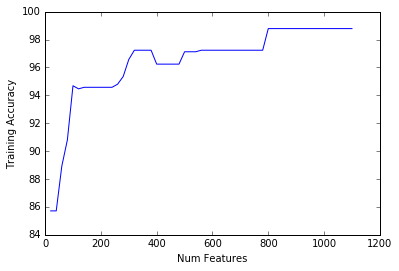

In [152]:
plt.plot(df_training.index.values, df_training['accuracy'])
plt.xlabel("Num Features")
plt.ylabel("Training Accuracy")
plt.show()

In [153]:
print("Results for Testing Data")
df_testing= pd.DataFrame(rows_testing, columns=['num_features', 'accuracy', 'TN', 'FP', 
                           'FN', 'TP', "Precision", "Recall"])

df_testing.set_index("num_features", inplace=True)
df_testing

Results for Testing Data


,accuracy,TN,FP,FN,TP,Precision,Recall
num_features,,,,,,,
20,99.262514,6326,0,47,0,NaN,0.000000
40,93.503844,5954,372,42,5,0.013263,0.106383
60,53.051938,3352,2974,18,29,0.009657,0.617021
80,0.737486,0,6326,0,47,0.007375,1.000000
100,47.356033,2996,3330,25,22,0.006563,0.468085
120,53.161776,3371,2955,30,17,0.005720,0.361702
140,50.196140,3182,3144,30,17,0.005378,0.361702
160,50.196140,3182,3144,30,17,0.005378,0.361702
180,50.164758,3180,3146,30,17,0.005375,0.361702


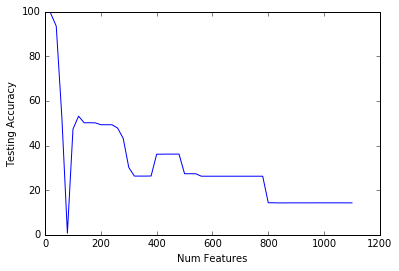

In [154]:
plt.plot(df_testing.index.values, df_testing['accuracy'])
plt.xlabel("Num Features")
plt.ylabel("Testing Accuracy")
plt.show()

In [155]:
testing_sorted = df_testing.sort_values(by="accuracy", ascending=False)
testing_sorted

,accuracy,TN,FP,FN,TP,Precision,Recall
num_features,,,,,,,
20,99.262514,6326,0,47,0,NaN,0.000000
40,93.503844,5954,372,42,5,0.013263,0.106383
120,53.161776,3371,2955,30,17,0.005720,0.361702
60,53.051938,3352,2974,18,29,0.009657,0.617021
140,50.196140,3182,3144,30,17,0.005378,0.361702
160,50.196140,3182,3144,30,17,0.005378,0.361702
180,50.164758,3180,3146,30,17,0.005375,0.361702
220,49.317433,3126,3200,30,17,0.005284,0.361702
200,49.317433,3126,3200,30,17,0.005284,0.361702
